## ENTRENAMIENTO SIN VALIDACIÓN CRUZADA

✅ Encontrados 225 parches JPEG en data\raw\pnoa
X shape: (225, 256, 256, 3) | y shape: (225, 256, 256, 1)
🧪 Train images: 180 | Val images: 45
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['sequential_1[0][0]']           
                                )               

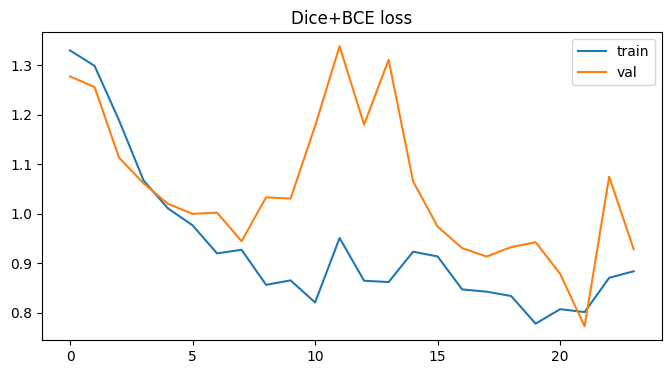

In [ ]:
# notebooks/04_Preentrenamiento_con_UNET_ligero

# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIGURACIÓN
# ------------------------------------------------------------------
from pathlib import Path
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
from tensorflow.keras.losses import BinaryCrossentropy

PROJECT_ROOT = Path().resolve().parent
SCRIPT_DIR   = PROJECT_ROOT / "scripts"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.append(str(SCRIPT_DIR))

from model_utils import load_unet_with_mobilenet, dice_loss

# Reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# ------------------------------------------------------------------
# 1. PATHS
# ------------------------------------------------------------------
RAW_DIR       = PROJECT_ROOT / "data" / "raw" / "pnoa"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_DIR     = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 2. CARGA Y PREPROCESADO DE DATOS
# ------------------------------------------------------------------
def load_image_mask(tile_jpg: Path, target_size=(256,256)):
    mask_tif = PROCESSED_DIR / f"{tile_jpg.stem}_MASK.tif"
    assert mask_tif.exists(), f"❌ Falta máscara para {tile_jpg.name}"

    # Leer y normalizar JPEG
    with rasterio.open(tile_jpg) as src:
        img = src.read([1,2,3]).transpose(1,2,0).astype(np.float32)
    img = tf.image.resize(img, target_size)
    img = img / 255.0

    # Leer y procesar máscara
    with rasterio.open(mask_tif) as src:
        msk = src.read(1).astype(np.float32)
    msk = tf.image.resize(msk[...,None], target_size, method='nearest')
    msk = tf.squeeze(msk)
    msk = tf.where(msk > 0.5, 1.0, 0.0)

    return img.numpy(), msk.numpy()

# Listar parches JPEG
image_paths = sorted(RAW_DIR.glob("valencia_tile_*.jpg"))
print(f"✅ Encontrados {len(image_paths)} parches JPEG en {RAW_DIR.relative_to(PROJECT_ROOT)}")

# Cargar todo en memoria
Xy = [load_image_mask(p) for p in image_paths]
X, y = zip(*Xy)
X = np.array(X, dtype=np.float32)
y = np.expand_dims(np.array(y, dtype=np.float32), -1)
print(f"X shape: {X.shape} | y shape: {y.shape}")

# ------------------------------------------------------------------
# 3. TRAIN-VAL SPLIT
# ------------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f"🧪 Train images: {X_train.shape[0]} | Val images: {X_val.shape[0]}")

# ------------------------------------------------------------------
# 4. DATA AUGMENTATION VIA TF.DATA
# ------------------------------------------------------------------
def tf_augment(img, msk):
    img = tf.image.random_flip_left_right(img)
    msk = tf.image.random_flip_left_right(msk)
    img = tf.image.random_flip_up_down(img)
    msk = tf.image.random_flip_up_down(msk)
    k = tf.random.uniform(shape=(), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k);    msk = tf.image.rot90(msk, k)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.7, upper=1.3)
    img = tf.image.random_saturation(img, lower=0.7, upper=1.3)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, msk

batch_size = 8
AUTOTUNE   = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train))
    .map(tf_augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# ------------------------------------------------------------------
# 5. LOSS COMBINADA (DICE + BCE) PARA REDUCIR RECALL
# ------------------------------------------------------------------
bce = BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred)

# ------------------------------------------------------------------
# 6. MODELO
# ------------------------------------------------------------------
model = load_unet_with_mobilenet(input_shape=(256,256,3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.MeanIoU(num_classes=2, name='iou')
    ]
)
model.summary()

# ------------------------------------------------------------------
# 7. CALLBACKS (+ EARLY STOPPING basado en la precision)
# ------------------------------------------------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_precision', mode='max', patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(MODEL_DIR / 'best_model.h5'),
        monitor='val_loss', save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=10
    )
]

# ------------------------------------------------------------------
# 8. ENTRENAMIENTO
# ------------------------------------------------------------------
EPOCHS = 50
print("\n🔥 Comenzando entrenamiento...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ------------------------------------------------------------------
# 9. GUARDADO DEL MODELO FINAL
# ------------------------------------------------------------------
model.save(MODEL_DIR / "final_model.h5")
print(f"\n✅ Modelo final guardado en {MODEL_DIR.relative_to(PROJECT_ROOT)}")

# ------------------------------------------------------------------
# 10. MOSTRAR CURVAS DE APRENDIZAJE
# ------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Dice+BCE loss'); plt.legend(); plt.show()


## ENTRENAMIENTO CON VALIDACIÓN CRUZADA (5 K-Fold)

✅ 225 imágenes en data\raw\pnoa
X shape: (225, 256, 256, 3) y shape: (225, 256, 256, 1)

=== Fold 1/5 ===
Epoch 1/50
23/23 - 335s - loss: 1.2895 - precision: 0.2271 - recall: 0.0375 - iou: 0.4246 - val_loss: 1.2924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.4325 - lr: 1.0000e-04 - 335s/epoch - 15s/step
Epoch 2/50
23/23 - 264s - loss: 1.2379 - precision: 0.1881 - recall: 0.0011 - iou: 0.4246 - val_loss: 1.4466 - val_precision: 0.8333 - val_recall: 1.1303e-04 - val_iou: 0.4325 - lr: 1.0000e-04 - 264s/epoch - 11s/step
Epoch 3/50
23/23 - 278s - loss: 1.0400 - precision: 0.5155 - recall: 0.3917 - iou: 0.4246 - val_loss: 1.2564 - val_precision: 0.9210 - val_recall: 0.2675 - val_iou: 0.4325 - lr: 1.0000e-04 - 278s/epoch - 12s/step
Epoch 4/50
23/23 - 304s - loss: 0.9356 - precision: 0.6122 - recall: 0.5257 - iou: 0.4246 - val_loss: 1.0378 - val_precision: 0.6790 - val_recall: 0.4694 - val_iou: 0.4325 - lr: 1.0000e-04 - 304s/epoch - 13s/step
Epoch 5/50
23/23 - 321s - loss

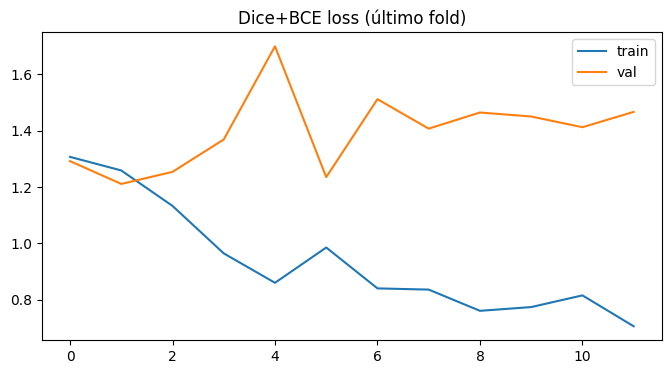

In [ ]:

# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIGURACIÓN
# ------------------------------------------------------------------
from pathlib import Path
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import sys
from tensorflow.keras.losses import BinaryCrossentropy

PROJECT_ROOT = Path().resolve().parent
SCRIPT_DIR   = PROJECT_ROOT / "scripts"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.append(str(SCRIPT_DIR))

from model_utils import load_unet_with_mobilenet, dice_loss

# reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# ------------------------------------------------------------------
# 1. PATHS 
# ------------------------------------------------------------------
RAW_DIR       = PROJECT_ROOT / "data" / "raw" / "pnoa"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_DIR     = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 2. CARGA Y PREPROCESADO DE DATOS
# ------------------------------------------------------------------
def load_image_mask(tile_jpg, target_size=(256,256)):
    mask_tif = PROCESSED_DIR / f"{tile_jpg.stem}_MASK.tif"
    assert mask_tif.exists(), f"Falta máscara {mask_tif.name}"
    with rasterio.open(tile_jpg) as src:
        img = src.read([1,2,3]).transpose(1,2,0).astype(np.float32)
    img = tf.image.resize(img, target_size) / 255.0
    with rasterio.open(mask_tif) as src:
        msk = src.read(1).astype(np.float32)
    msk = tf.image.resize(msk[...,None], target_size, method='nearest')
    msk = tf.squeeze(msk)
    msk = tf.where(msk>0.5,1.0,0.0)
    return img.numpy(), msk.numpy()

paths = sorted(RAW_DIR.glob("valencia_tile_*.jpg"))
print(f"✅ {len(paths)} imágenes en {RAW_DIR.relative_to(PROJECT_ROOT)}")

data = [load_image_mask(p) for p in paths]
X, y = zip(*data)
X = np.array(X, dtype=np.float32)
y = np.expand_dims(np.array(y, dtype=np.float32), -1)
print("X shape:", X.shape, "y shape:", y.shape)

# ------------------------------------------------------------------
# 3. DATA AUGMENTATION VIA TF.DATA
# ------------------------------------------------------------------
def tf_augment(img, msk):
    img = tf.image.random_flip_left_right(img); msk = tf.image.random_flip_left_right(msk)
    img = tf.image.random_flip_up_down(img);    msk = tf.image.random_flip_up_down(msk)
    k   = tf.random.uniform((),0,4,tf.int32)
    img = tf.image.rot90(img,k);                msk = tf.image.rot90(msk,k)
    img = tf.image.random_brightness(img,0.2)
    img = tf.image.random_contrast(img,0.7,1.3)
    img = tf.image.random_saturation(img,0.7,1.3)
    return tf.clip_by_value(img,0,1), msk

batch_size = 8
AUTOTUNE   = tf.data.AUTOTUNE

# ------------------------------------------------------------------
# 4. LOSS COMBINADA (DICE + BCE) PARA REDUCIR RECALL
# ------------------------------------------------------------------
bce = BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred)

# ------------------------------------------------------------------
# 5. ENTRENAMIENTO CON VALIDACIÓN CRUZADA
# ------------------------------------------------------------------
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
all_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n=== Fold {fold}/{n_splits} ===")

    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    train_ds = (tf.data.Dataset
                .from_tensor_slices((X_tr, y_tr))
                .shuffle(len(X_tr))
                .map(tf_augment, num_parallel_calls=AUTOTUNE)
                .batch(batch_size).prefetch(AUTOTUNE))
    val_ds = (tf.data.Dataset
              .from_tensor_slices((X_va, y_va))
              .batch(batch_size).prefetch(AUTOTUNE))

    # Nuevo modelo por fold
    model = load_unet_with_mobilenet(input_shape=(256,256,3))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=combined_loss,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.MeanIoU(num_classes=2, name='iou')
        ]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',     patience=10, restore_best_weights=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_precision',mode='max',patience=8,  restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        verbose=2
    )

    # evaluar en validación
    scores = model.evaluate(val_ds, verbose=0)
    names  = model.metrics_names
    metrics = dict(zip(names, scores))
    print(f"-> Fold {fold} metrics:", metrics)
    all_metrics.append([metrics[m] for m in names])

# ------------------------------------------------------------------
# 5. RESULTADOS PROMEDIO
# ------------------------------------------------------------------
all_metrics = np.array(all_metrics)
avg = all_metrics.mean(axis=0)
print("\n=== CV promedio ===")
for name, val in zip(names, avg):
    print(f"{name:12s}: {val:.4f}")

# ------------------------------------------------------------------
# 6. GUARDAR ÚLTIMO MODELO
# ------------------------------------------------------------------
model.save(MODEL_DIR / f"final_model_fold{fold}.h5")
print(f"\n✅ Guardado modelo fold {fold} en '{MODEL_DIR.relative_to(PROJECT_ROOT)}'")

# ------------------------------------------------------------------
# 7. CURVAS DE APRENDIZAJE 
# ------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Dice+BCE loss (último fold)'); plt.legend(); plt.show()
